In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import importlib
import torch
import pandas as pd
import os
import sys
import json
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from recover.utils.utils import get_tensor_dataset
import recover_data_lake as rdl
from copy import deepcopy
import numpy as np
from tqdm import tqdm
import umap
from sklearn.decomposition import PCA

In [11]:
#####################################
# Iterator over trainers for a given config
#####################################

def trainer_iterator(config_file, path_to_conf):
    configuration = importlib.import_module("recover.config." + config_file).configuration

    # Loop over all runs for this configuration
    for run_dir in tqdm(os.listdir(os.path.join(path_to_conf, config_file))):
        print(run_dir)
        if run_dir.startswith('BasicTrainer'):

            this_run_results = {}

            # Load params for that run
            with open(os.path.join(path_to_conf, config_file, run_dir, 'params.json')) as f:
                params = json.load(f)

            # Load configuration (can contain grid_search args)
            this_run_config = deepcopy(configuration)

            # Replace grid_search args by the actual parameter for that run
            for key in this_run_config['trainer_config']:
                if type(this_run_config['trainer_config'][key]) is dict \
                and 'grid_search' in this_run_config['trainer_config'][key].keys():
                    
                    # If grid search over python classes, we need to load them
                    if type(params[key]) is str and params[key].startswith('<class'):
                        class_to_load = params[key]
                        class_to_load = class_to_load.split("'")[1]
                        class_to_load = class_to_load.rpartition('.')
                        path_to_class = class_to_load[0]
                        class_to_load_name = class_to_load[-1]
                        params[key] = getattr(importlib.import_module(path_to_class), 
                                              class_to_load_name)
                    this_run_config['trainer_config'][key] = params[key]
                    this_run_results[key] = params[key]

            # Load trainer
            trainer = this_run_config["trainer"](this_run_config["trainer_config"])

            # Find the checkpoint corresponding to the best epoch (always two checkpoints, 
            # corresponding to best and last epochs)
            cpt = 0
            checkpoint = None
            for dir_check in os.listdir(os.path.join(path_to_conf, config_file, run_dir)):
                if dir_check.startswith('checkpoint'):
                    cpt += 1
                    if checkpoint is None:
                        checkpoint = dir_check
                    else:
                        if int(dir_check.split('_')[-1]) < int(checkpoint.split('_')[-1]):
                            checkpoint = dir_check
                            
            if cpt == 2:
                # Only yield trainer if 2 checkpoints have been saved (corresponding to best and last epochs)

                # Load model
                trainer.model.load_state_dict(torch.load(path_to_conf + config_file + "/" + 
                                                 run_dir + "/" + checkpoint + "/model.pth",
                                                 map_location=torch.device('cpu')))
                print("Loaded model from", run_dir, checkpoint)
                
                yield trainer


#####################################
# Main plotting method
#####################################


def plot_drug_embeddings(config_file, path_to_conf):                
    all_results = pd.DataFrame()
    
    cpt = 0
                
    trainer = next(trainer_iterator(config_file, path_to_conf))
    cpt += 1
    # Retrieve DTI information
    dtis = rdl.get_dtis('chembl_dtis.csv')
    dtis_restr = dtis[dtis['recover_id'].apply(lambda id: id in trainer.data.rec_id_to_idx_dict.keys())]
    dtis_restr = dtis_restr[dtis_restr["pchembl_value"] > 6]

    all_targets = dtis_restr["gene_hgnc_id"].unique().tolist()
    all_targets_dict = {all_targets[i]: i for i in range(len(all_targets))}

    # Binary array of shape (n_drugs, n_targets)
    all_labels = np.zeros((len(trainer.data.x_drugs), len(all_targets)))

    for i in dtis_restr.index:
        name = dtis_restr.at[i, 'recover_id']
        drug_idx = trainer.data.rec_id_to_idx_dict[name]
        target = dtis_restr.at[i, "gene_hgnc_id"]
        target_idx = all_targets_dict[target]

        all_labels[drug_idx, target_idx] = 1

    # Keep labels which cover more than 3 drugs
    targets_to_keep = all_labels.sum(axis=0) > 3
    all_labels = all_labels[:, targets_to_keep]
    all_targets = [all_targets[i] for i in range(len(all_targets)) if targets_to_keep[i]]

    pca = PCA(n_components=3)
    all_labels_transformed = pca.fit_transform(all_labels)

    with torch.no_grad():
        drug_emb = trainer.model.predictor.before_merge_mlp([trainer.data.x_drugs,
                                                            torch.zeros(trainer.data.x_drugs.shape[0])])

    drug_emb = drug_emb[0].numpy()

    # Save dataframe of drug embeddings
    result_dataframe = pd.DataFrame(drug_emb, columns = ['drug_emb_' + str(i) for i in 
                                                         range(drug_emb.shape[1])])

    drug_idx_to_rec_id_dict = {v: k for k, v in trainer.data.rec_id_to_idx_dict.items()}
    result_dataframe = pd.concat((result_dataframe, pd.DataFrame(all_labels, columns=all_targets)), axis=1)
    result_dataframe['recover_id'] = [drug_idx_to_rec_id_dict[i] for i  in range(drug_emb.shape[0])]
    result_dataframe = result_dataframe.set_index('recover_id', drop=True)

    result_dataframe.to_csv("/Users/paul/PycharmProjects/RECOVERcoalition/Recover/recover/"
                                      "notebooks/drug_embeddings_after_round_5.csv")

    # Compute UMAP of drug embeddings
    drug_umap_emb = umap.UMAP(
                            n_components=2,
                            metric='cosine'
                             ).fit_transform(drug_emb)

    for i in range(3):
        plt.figure(figsize=(6, 4), dpi=300)
        ax = plt.scatter(drug_umap_emb[:, 0], drug_umap_emb[:, 1], c=all_labels_transformed[:, i],
                        cmap="plasma")
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        plt.title("seed " + str(cpt) + " and pca component " + str(i))
        plt.show()
        

  0%|          | 0/4 [00:00<?, ?it/s]


BasicTrainer_0_seed=2_2022-07-25_10-16-450nfcrum8
Initializing regular training pipeline
Dataset loaded.
4463 drug comb experiments among 152 drugs
	 fingeprints with radius 2 and nbits 1024
	 drug features dimension 1176
	 1 cell-lines
model initialized randomly
Baseline(
  (criterion): MSELoss()
  (predictor): BilinearMLPPredictor(
    (before_merge_mlp): Sequential(
      (0): LinearModule(in_features=1176, out_features=2048, bias=True)
      (1): ReLUModule()
      (2): LinearModule(in_features=2048, out_features=128, bias=True)
      (3): ReLUModule()
    )
    (after_merge_mlp): Sequential(
      (0): LinearModule(in_features=128, out_features=64, bias=True)
      (1): ReLUModule()
      (2): LinearModule(in_features=64, out_features=1, bias=True)
    )
  )
)
Loaded model from BasicTrainer_0_seed=2_2022-07-25_10-16-450nfcrum8 checkpoint_19


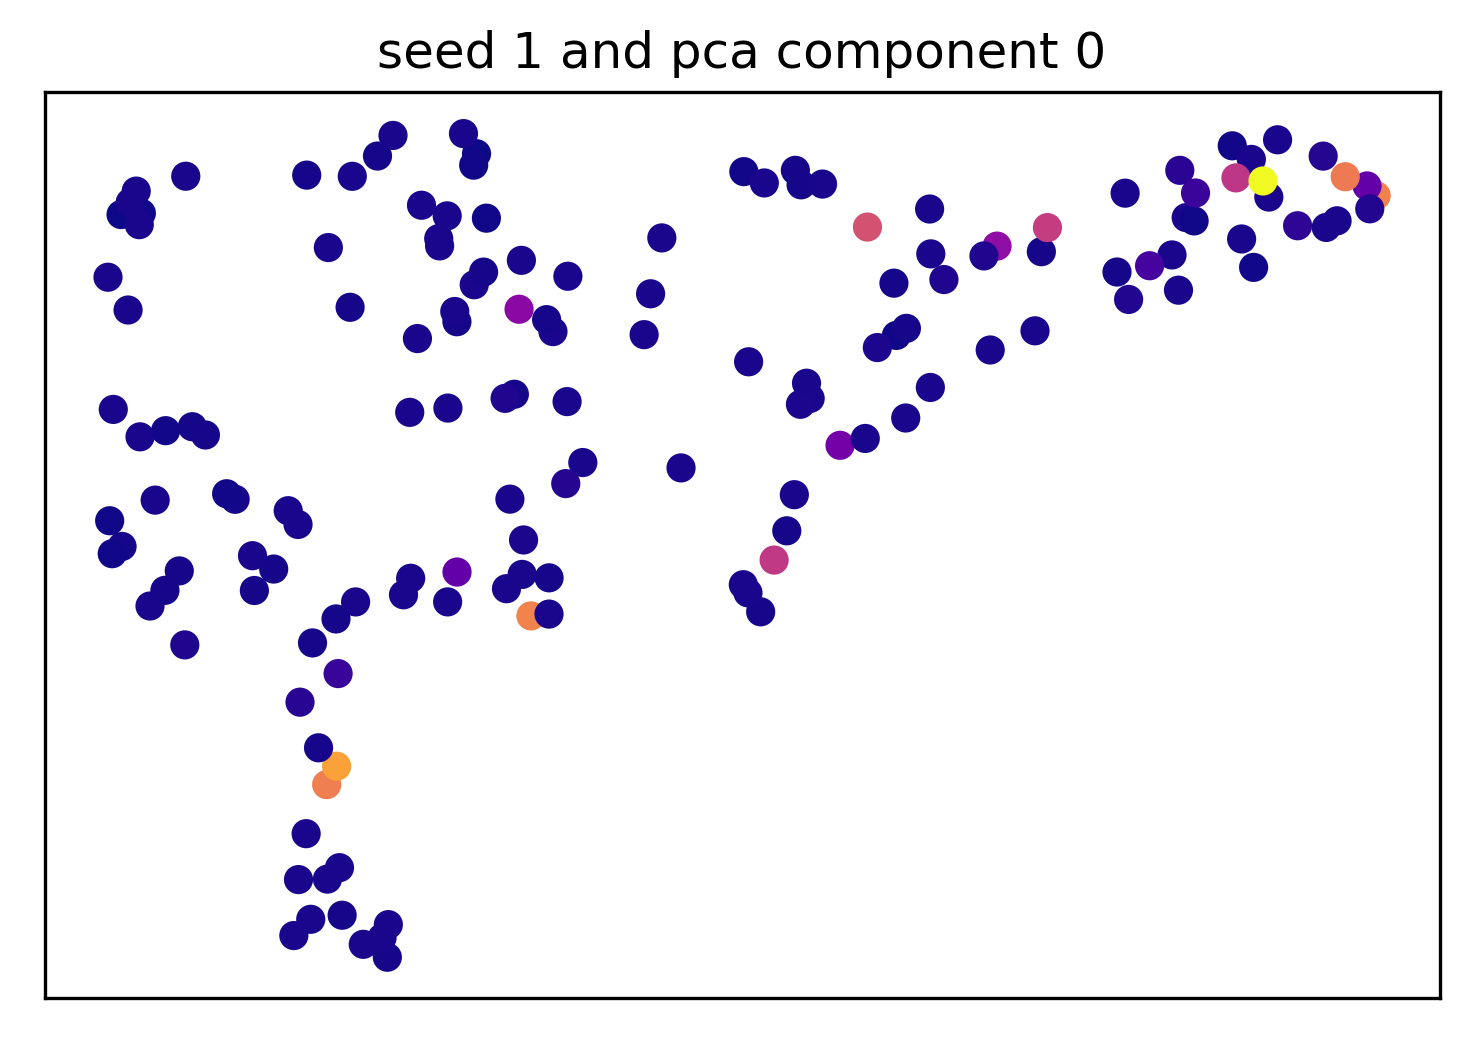

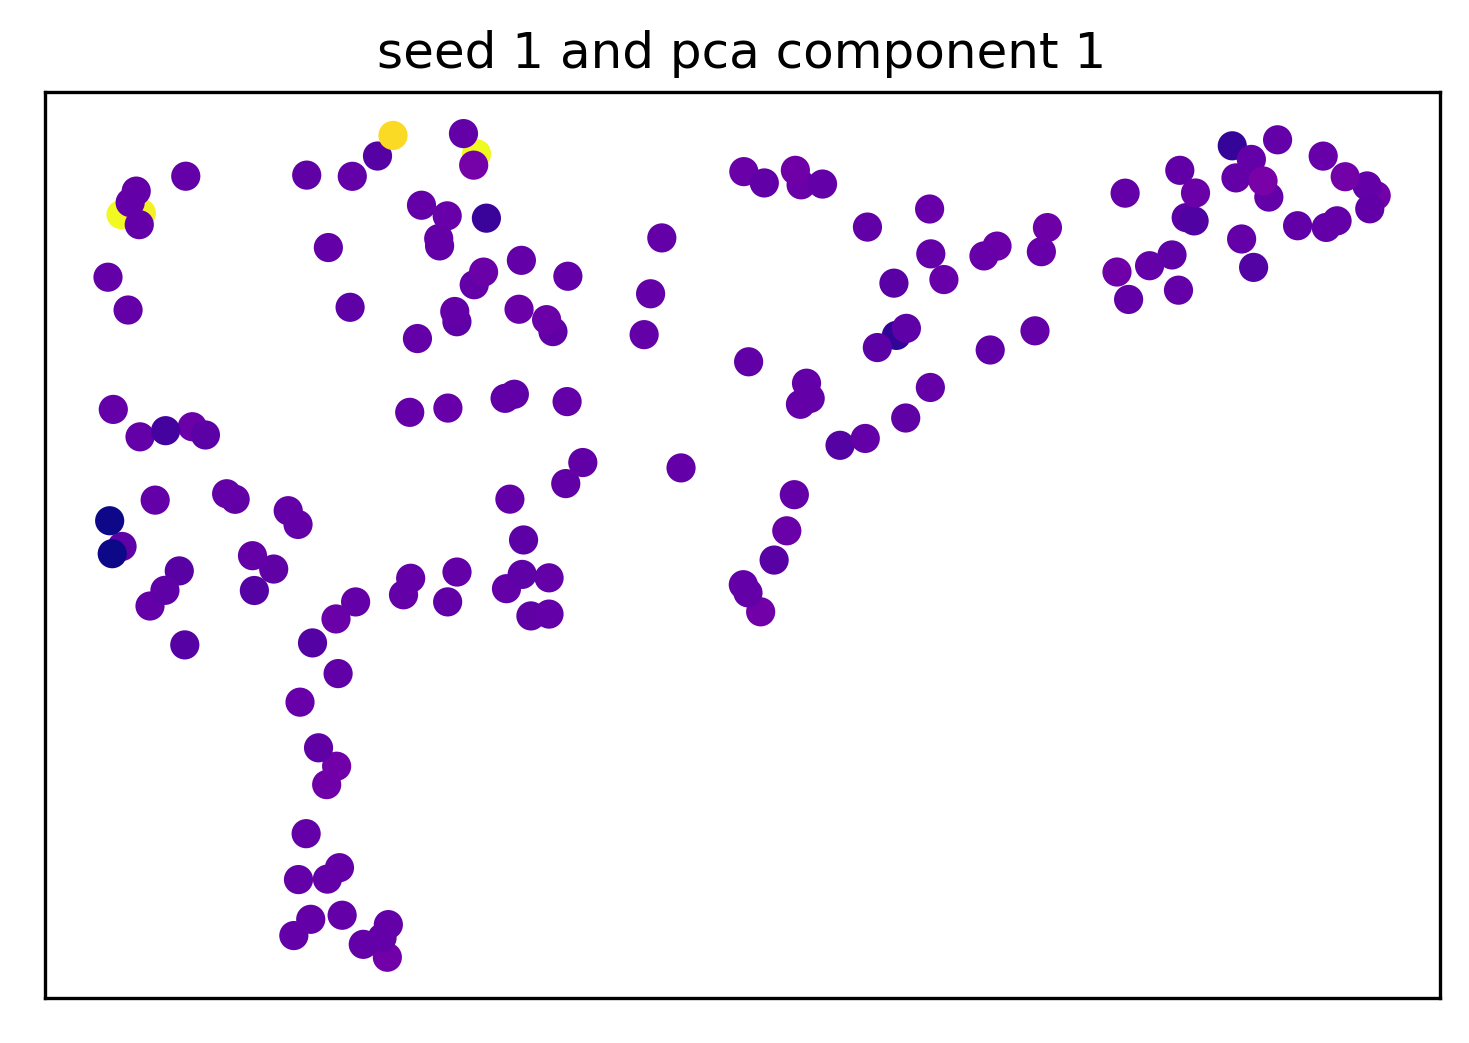

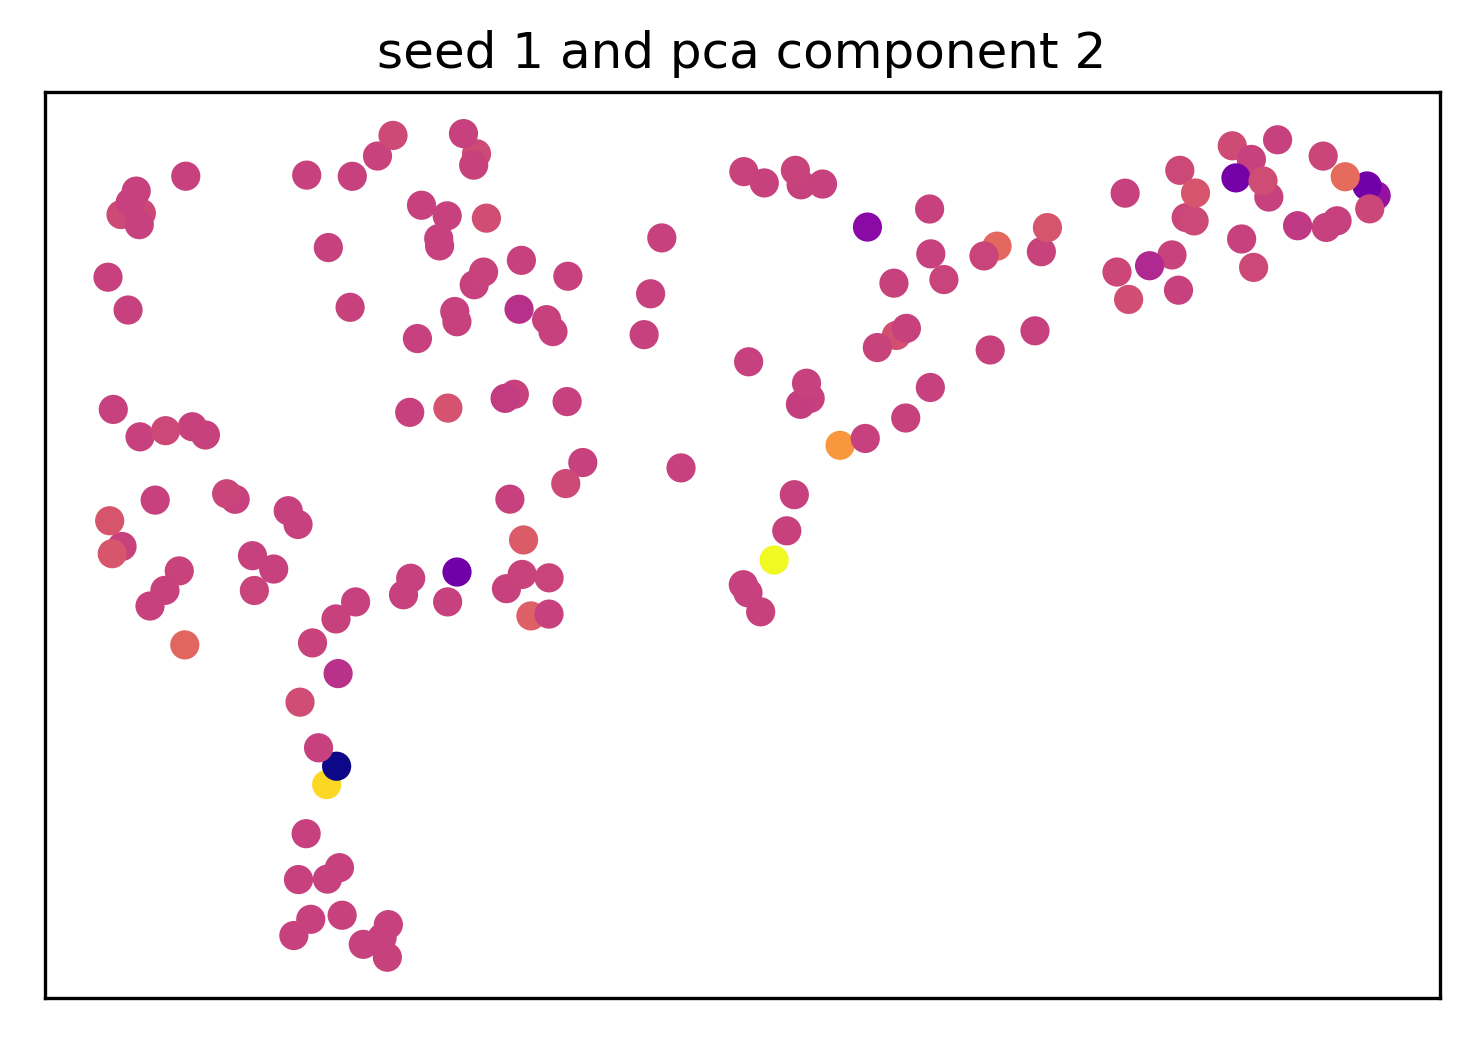

In [12]:
plot_drug_embeddings(config_file="training_after_round_5", 
             path_to_conf="/Users/paul/PycharmProjects/RECOVERcoalition/Recover/RayLogs/")